## Load Dataset

In [1]:
import os
import pandas as pd
from scipy.stats import zscore
import matplotlib as matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import squarify
import plotly.express as px

from IPython.display import display, HTML

In [2]:
df = pd.read_csv("data\Occupancy.csv")
df.head().T

,0,1,2,3,4
date,2015-02-02 14:19:00,2015-02-02 14:19:59,2015-02-02 14:21:00,2015-02-02 14:22:00,2015-02-02 14:23:00
Temperature,23.7,23.718,23.73,23.7225,23.754
Humidity,26.272,26.29,26.23,26.125,26.2
Light,585.2,578.4,572.666667,493.75,488.6
CO2,749.2,760.4,769.666667,774.75,779.0
HumidityRatio,0.004764,0.004773,0.004765,0.004744,0.004767
Occupancy,1,1,1,1,1


# Check columns in dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20560 entries, 0 to 20559
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           20560 non-null  object 
 1   Temperature    20560 non-null  float64
 2   Humidity       20560 non-null  float64
 3   Light          20560 non-null  float64
 4   CO2            20560 non-null  float64
 5   HumidityRatio  20560 non-null  float64
 6   Occupancy      20560 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 1.1+ MB


In [4]:
df.shape

(20560, 7)

# Check for missing values

In [5]:
df.isnull().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

# Look at basic statistics

In [6]:
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


### Select only float-type columns (continuous numeric data)

In [7]:
numeric_cols = df.select_dtypes(include=['float32', 'float64']).columns
numeric_cols

Index(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], dtype='object')

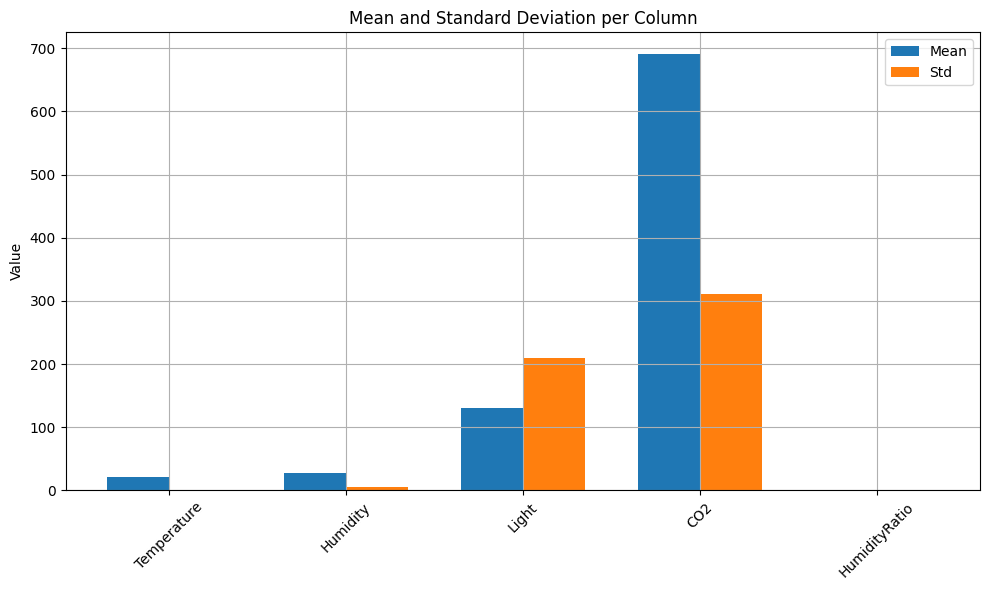

In [8]:
# Compute stats
means = df[numeric_cols].mean()
stds = df[numeric_cols].std()

# Bar width and position
x = np.arange(len(numeric_cols))
width = 0.35

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, means, width, label='Mean')
plt.bar(x + width/2, stds, width, label='Std')

# Labels
plt.xticks(x, numeric_cols, rotation=45)
plt.ylabel("Value")
plt.title("Mean and Standard Deviation per Column")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Cleaning the dataset

### Check for duplicates

In [9]:
df['date'].duplicated().sum()

np.int64(0)

### Check outliers

In [10]:
# Lists to collect outliers as DataFrames for each method
iqr_outliers_all = []
zscore_outliers_all = []

for col in numeric_cols:
    print(f"\nColumn: {col}")

    # IQR Method
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"  🔹 IQR outliers: {len(iqr_outliers)}")
    if not iqr_outliers.empty:
        temp = iqr_outliers[[col]].copy()
        temp["column"] = col
        temp["method"] = "IQR"
        iqr_outliers_all.append(temp)

    # Z-Score Method
    valid = df[col].dropna()
    zscores = zscore(valid)
    zscore_outliers = df.loc[valid.index[abs(zscores) > 3]]
    print(f"  🔸 Z-Score outliers (>3): {len(zscore_outliers)}")
    if not zscore_outliers.empty:
        temp = zscore_outliers[[col]].copy()
        temp["column"] = col
        temp["method"] = "Z-Score"
        zscore_outliers_all.append(temp)

# Combine all outliers into unified DataFrames
df_iqr_outliers = pd.concat(iqr_outliers_all, ignore_index=True) if iqr_outliers_all else pd.DataFrame()
df_zscore_outliers = pd.concat(zscore_outliers_all, ignore_index=True) if zscore_outliers_all else pd.DataFrame()


Column: Temperature
  🔹 IQR outliers: 519
  🔸 Z-Score outliers (>3): 143

Column: Humidity
  🔹 IQR outliers: 0
  🔸 Z-Score outliers (>3): 0

Column: Light
  🔹 IQR outliers: 183
  🔸 Z-Score outliers (>3): 162

Column: CO2
  🔹 IQR outliers: 1449
  🔸 Z-Score outliers (>3): 271

Column: HumidityRatio
  🔹 IQR outliers: 0
  🔸 Z-Score outliers (>3): 0


### Look what columns are containning outliers

In [11]:
print(f"Columns with IQR outliers: {df_iqr_outliers.column.unique()}")
print(f"Columns with zscore outliers: {df_zscore_outliers.column.unique()}")

Columns with IQR outliers: ['Temperature' 'Light' 'CO2']
Columns with zscore outliers: ['Temperature' 'Light' 'CO2']


### Combine them

In [12]:
iqr_outlier_columns = list(df_iqr_outliers["column"].unique())
zscore_outlier_columns = list(df_zscore_outliers["column"].unique())

# Columns common to both methods
outlier_columns = list(set(iqr_outlier_columns) & set(zscore_outlier_columns))
outlier_columns

['Temperature', 'CO2', 'Light']

### Visualize columns with outliers (Box-plot, Violin-plot)

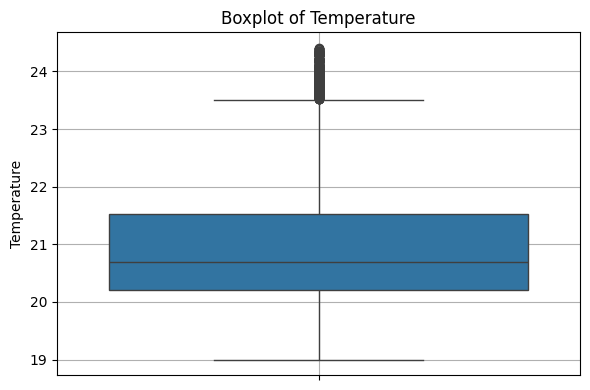

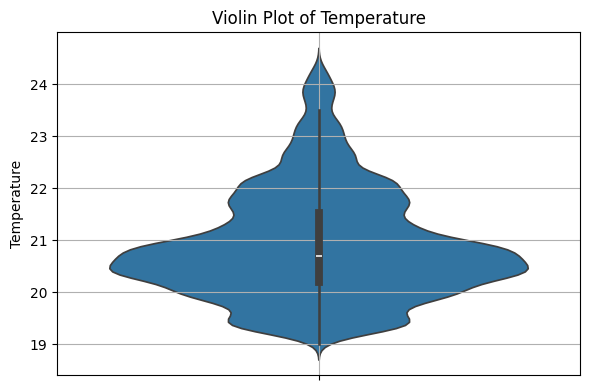

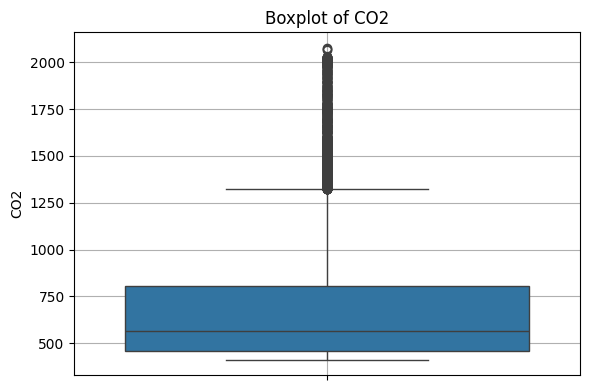

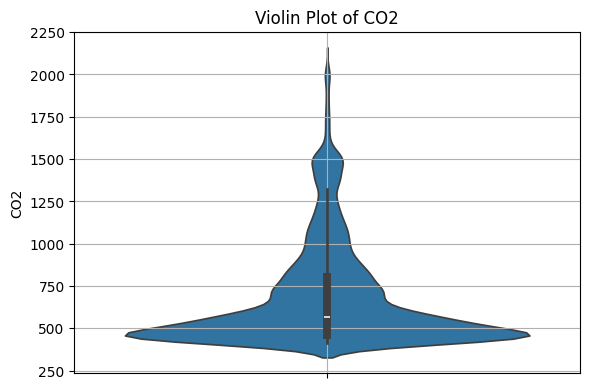

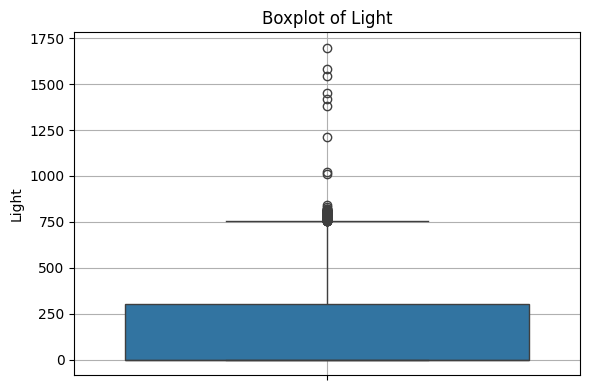

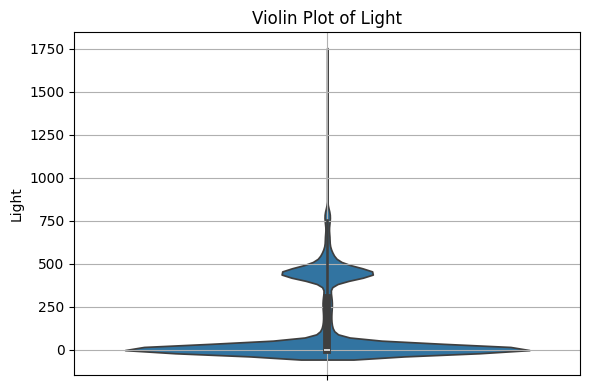

In [13]:
for col in outlier_columns:
    # --- Boxplot ---
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df, y=col)
    plt.title(f'Boxplot of {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Violin Plot ---
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=df, y=col)
    plt.title(f'Violin Plot of {col}')
    plt.ylabel(col)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Looking at different correlations

###  Environmental Variables vs. Occupancy (Pearson correlation)

In [ ]:
# Select only numeric columns
numeric_df = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy']]

# Calculate Pearson correlation matrix
pearson_corr = numeric_df.corr(method='pearson')

# Correlation with Occupancy only
occupancy_corr = pearson_corr['Occupancy'].drop('Occupancy').reset_index()
occupancy_corr.columns = ['Feature', 'correlation']

# Bar plot using Plotly
fig = px.bar(
    occupancy_corr,
    x='Feature',
    y='correlation',
    color='correlation',
    color_continuous_scale='RdBu',
    title='Pearson Correlation with Occupancy',
    text=occupancy_corr['correlation'].round(2)
)
fig.update_layout(yaxis_title='Correlation Coefficient', coloraxis_colorbar=dict(title='Correlation'))
fig.show()


### Look at range of time in 'date' column

In [17]:
# Convert to datetime if not already
df['date'] = pd.to_datetime(df['date'])

# Check min and max timestamps
start_date = df['date'].min()
end_date = df['date'].max()

print(f"📅 Data ranges from: {start_date} to {end_date}")
print(f"🕒 Total duration: {end_date - start_date}")


📅 Data ranges from: 2015-02-02 14:19:00 to 2015-02-18 09:19:00
🕒 Total duration: 15 days 19:00:00


### Correlation between time and light throughout the day (light mean x hour of day)

In [18]:
# Convert 'date' column to datetime (if not already)
df['date'] = pd.to_datetime(df['date'])

# Extract the hour from the timestamp
df['hour'] = df['date'].dt.hour

# Group by hour and calculate mean light level
hourly_light = df.groupby('hour')['Light'].mean().reset_index()

# Plot with Plotly
fig = px.line(
    hourly_light,
    x='hour',
    y='Light',
    title='Average Light Levels by Hour of Day',
    markers=True
)
fig.update_layout(
    xaxis_title='Hour of Day',
    yaxis_title='Average Light',
    xaxis=dict(dtick=1),
    template='plotly_white'
)
fig.show()


### Density Plot Comparison (CO2 x Occupancy)

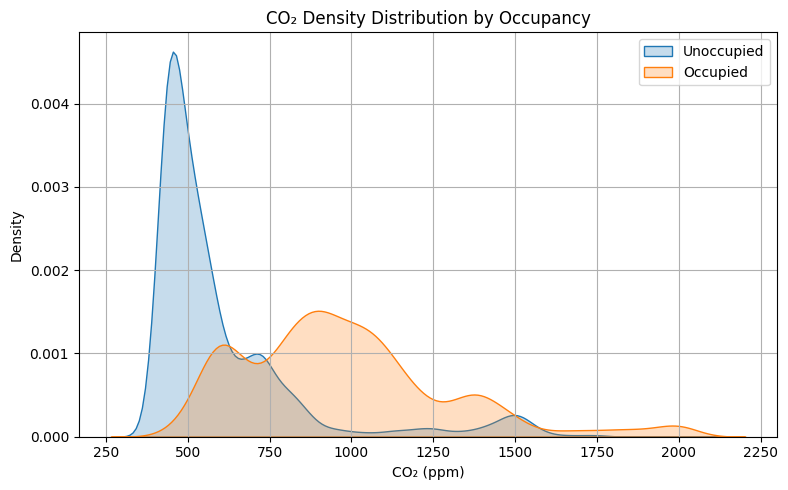

In [21]:
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df[df['Occupancy'] == 0], x='CO2', label='Unoccupied', fill=True)
sns.kdeplot(data=df[df['Occupancy'] == 1], x='CO2', label='Occupied', fill=True)
plt.title('CO₂ Density Distribution by Occupancy')
plt.xlabel('CO₂ (ppm)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### test if CO2 is skewed

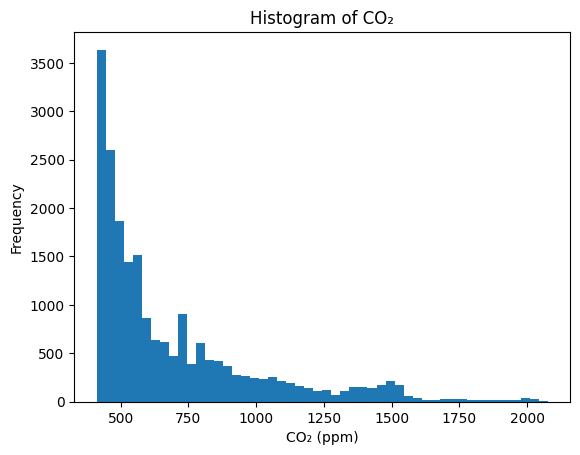

In [22]:
import matplotlib.pyplot as plt
plt.hist(df['CO2'], bins=50)
plt.title("Histogram of CO₂")
plt.xlabel("CO₂ (ppm)")
plt.ylabel("Frequency")
plt.show()
